Here we fit models across fish, looking at the latent representations of different conditions for all fish in the same 
low-d space.  We initialize with shared posteriors, use these for initialization when fitting with the individual posteriors and then use early stopping to prevent overfitting when fitting with the individual posteriors.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
from itertools import chain
from pathlib import Path

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.matrix_visualization import cmp_n_mats


from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.data_processing import load_and_preprocess_data
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_basic_posteriors
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import GNLDRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject
ps['fit_specs'] = {8: ['omr_forward', 'omr_left', 'omr_right'], 
                   9: ['omr_forward', 'omr_left', 'omr_right'], 
                   10: ['omr_forward', 'omr_left', 'omr_right'], 
                   11: ['omr_forward', 'omr_left', 'omr_right']} 
               
# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Number of latent variables in the model
ps['n_latent_vars'] = 3

# Dimensionality of the intermediate latent space
ps['n_intermediate_latent_vars'] = 10

# Number of inidividual slices of each type of subperiod we use for validation
ps['n_validation_slices'] = 2

# True if we should use GPUs for fitting if they are available
ps['use_gpus'] = True

# Options for setting up hypercube functions
ps['hc_opts'] = {'n_divisions_per_dim': [50, 30, 17], 
                 'dim_ranges': np.asarray([[0, 990.0], [0, 610.0], [0, 350.0]]),
                 'n_div_per_hc_side_per_dim': [1, 1, 1]}

# Hyperparameters determining the structure of the densenet underlying the m-module
ps['m_n_layers'] = 2
ps['m_growth_rate'] = 2

# Parameters for the priors on scales
ps['s_mn'] = 1.0
ps['s_std'] = .0001

# True if we should use early stopping
ps['use_early_stopping'] = True

# Folder where checkpoints will be saved
ps['cp_save_folder'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/glndr_testing'

## See which devices are available for fitting

In [5]:
if ps['use_gpus']:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]

Found 1 GPUs


## Load the data for each subject

In [6]:
subjects = list(ps['fit_specs'].keys())
n_subjects = len(subjects)

In [7]:
datasets, neuron_locs = load_and_preprocess_data(data_folder=ps['data_dir'], 
                                                 subjects=subjects, 
                                                 neural_gain=10)

Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_10.
Done loading data for subject subject_11.


## Form the fitting and validation data for each subject

In [8]:
all_subperiods = set(chain(*[v for v in ps['fit_specs'].values()]))
label_map = {sp: sp_i for sp_i, sp in enumerate(all_subperiods)}

In [9]:
fit_data = dict()
validation_data = dict()
fit_labels = dict()
validation_labels = dict()

for s_n, dataset in datasets.items():
    
    data_n = datasets[s_n].ts_data['dff']['vls'][:]
    
    # Label the subperiods for this subject
    subperiods = label_subperiods(dataset.ts_data['stim']['vls'][:])
    
    # Down select to only the subperiods we want to fit on for this subject
    subperiods = {k:v for k, v in subperiods.items() if k in ps['fit_specs'][s_n]}
    
    # Down select to the shock condition we want to fit
    subperiods = {k: [sp_i for sp_i in v if sp_i['shock'] == ps['shock']] for k, v in subperiods.items()} 
    
    # Randomly select subperiods for training and validation
    fit_subperiods = dict()
    validation_subperiods = dict()
    for sp_key, sp_slices in subperiods.items():
        
        n_slices = len(sp_slices)
        validation_inds = np.random.choice(n_slices, ps['n_validation_slices'], replace=False)
        
        validation_slices = [sp_slices[s_i] for s_i in range(n_slices) if s_i in validation_inds]
        fit_slices = [sp_slices[s_i] for s_i in range(n_slices) if s_i not in validation_inds]
        
        validation_subperiods[sp_key] = validation_slices
        fit_subperiods[sp_key] = fit_slices

    # Pull out the fitting data for this subject
    fit_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) 
                     for k, v in fit_subperiods.items()}
    
    validation_data[s_n] = {k:np.concatenate([data_n[sl['slice'], :] for sl in v], axis=0) 
                            for k, v in validation_subperiods.items()}
    
    # Generate numerical labels for each data point
    fit_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                       for k, v in fit_subperiods.items()}
    validation_labels[s_n] = {k:label_map[k]*np.ones(np.sum([sl_i['slice'].stop - sl_i['slice'].start for sl_i in v])) 
                              for k, v in validation_subperiods.items()}
    

In [10]:
fit_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) 
                 for k, v in fit_data.items()}
fit_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) 
                   for k, v in fit_labels.items()}

validation_data_conc = {k: np.concatenate([data for data in v.values()], axis=0) 
                        for k, v in validation_data.items()}
validation_labels_conc = {k: np.concatenate([lbls for lbls in v.values()], axis=0) 
                          for k, v in validation_labels.items()}

## Prepare things we will need for eventual plotting

In [11]:
n_subperiods = len(label_map)
subperiod_clrs = {k: cm.Set1(k_i/(n_subperiods-1)) for k_i, k in enumerate(label_map.keys())}
subject_markers = {8: 'o', 9: 'v', 10: 's', 11:'X'}

## Setup everything for fitting sp models

In [12]:
ind_n_vars = [validation_data_conc[s_n].shape[1] for s_n in subjects]

In [13]:
sp_m_fit = torch.nn.Sequential(DenseLNLNet(nl_class=torch.nn.ReLU, 
                                         d_in=ps['n_latent_vars'], 
                                         n_layers=ps['m_n_layers'], 
                                         growth_rate=ps['m_growth_rate'], 
                                         bias=True), 
                                 torch.nn.Linear(in_features=ps['n_latent_vars']+ps['m_n_layers']*ps['m_growth_rate'], 
                                                 out_features=ps['n_intermediate_latent_vars'], 
                                                 bias=True))

In [14]:
sp_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=ps['n_intermediate_latent_vars'],
                                                hc_params = ps['hc_opts'], s_mn=ps['s_mn'] , s_std=ps['s_std'] )
    
sp_posteriors = generate_basic_posteriors(n_obs_vars=[fit_data_conc[s_n].shape[1] for s_n in subjects], 
                                          n_smps=[fit_data_conc[s_n].shape[0] for s_n in subjects], 
                                          n_latent_vars=ps['n_latent_vars'], 
                                          n_intermediate_latent_vars=ps['n_intermediate_latent_vars'],
                                          s_opts={'mn_mn': ps['s_mn'], 'mn_std': .00000001, 
                                                  'std_lb': ps['s_std']-.0001, 'std_iv': ps['s_std']})

sp_posteriors = {s_n: sp_posteriors[s_i] for s_i, s_n in enumerate(subjects)}

sp_fit_mdls = {s_n: GNLDRMdl(n_latent_vars=ps['n_latent_vars'], m=sp_m_fit) for s_n in subjects}
                    
                                    
sp_vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                                  props=neuron_locs[s_n],
                                  mdl = sp_fit_mdls[s_n],
                                  posteriors = sp_posteriors[s_n]) for s_n in subjects]

for vi_coll in sp_vi_collections:
    vi_coll.posteriors.lm_post = sp_priors.lm_prior
    vi_coll.posteriors.mn_post = sp_priors.mn_prior

## Fit the sp models

In [15]:
sp_fitter = Fitter(vi_collections=sp_vi_collections, priors=sp_priors, devices=devices)

In [16]:
sp_fitter.distribute(distribute_data=True, devices=devices)
sp_logs = [sp_fitter.fit(1000, milestones=[100], update_int=100, init_lr=.1) for fit_r in range(1)]
sp_fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 8.40e+10
----------------------------------------
NELL: 2.71e+08, 8.09e+07, 5.52e+07, 7.92e+07
Latent KL: 7.32e+01, 1.83e+01, 5.53e+00, 1.83e+01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 1.71e+04, 1.94e+04, 2.03e+04, 2.36e+04
S KL: 1.73e+10, 1.99e+10, 2.08e+10, 2.54e+10
----------------------------------------
LR: 0.1
Elapsed time (secs): 1.483745813369751
----------------------------------------
CPU cur memory used (GB): 3.22e+01
GPU_0 cur memory used (GB): 7.26e-01, max memory used (GB): 7.26e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 2.22e+08
----------------------------------------
NELL: 1.29e+08, 3.38e+07, 2.32e+07, 3.59e+07
Latent KL: 1.74e+04, 4.74e+03, 2.41e+03, 4.18e+03
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 7.07e+04, 7.71e+04, 7.86e+04, 8.37e+04
S KL: 1.55e+02, 4.65e+01, 3.29e+01, 5.11e+01
-------------

## Examine logs of sp fitting performance

<IPython.core.display.Javascript object>


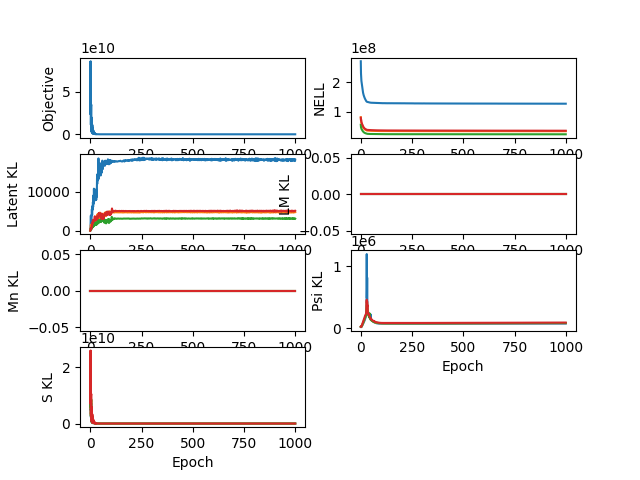

In [17]:
for log in sp_logs:
    sp_fitter.plot_log(log)

## View latents estimated with the sp models

In [18]:
view_validaton = False # True if we should view validation latents

In [19]:
sp_latents = {s_n: sp_posteriors[s_n].latent_post.mns.detach().numpy() for s_n in subjects}

<IPython.core.display.Javascript object>


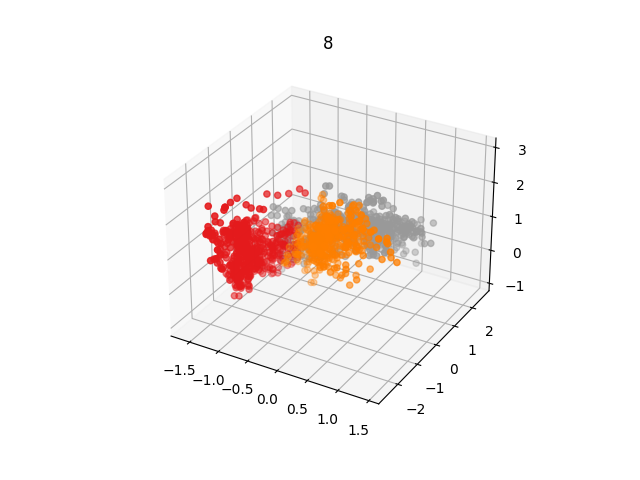

<IPython.core.display.Javascript object>


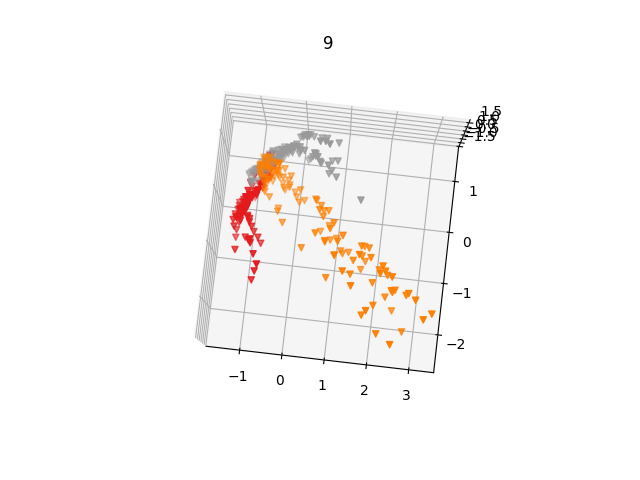

<IPython.core.display.Javascript object>


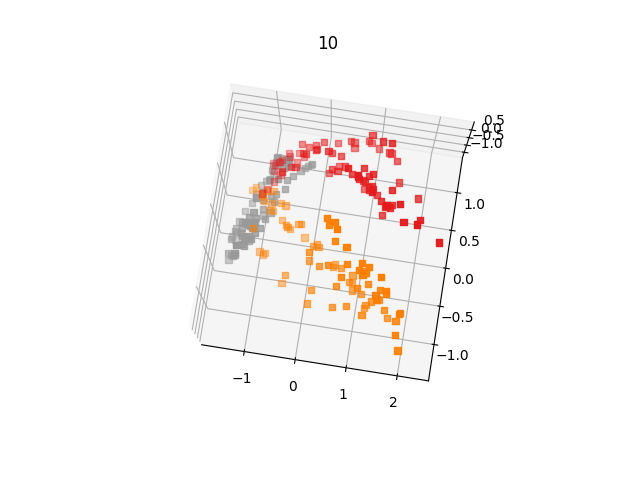

<IPython.core.display.Javascript object>


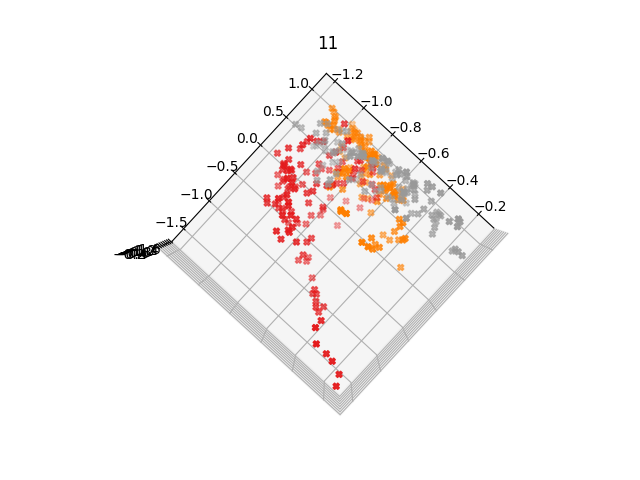

In [20]:
start_dim=0


for s_n in subjects:
    plt.figure()
    ax = plt.axes(projection='3d')
    plot_latents = sp_latents[s_n]
    if view_validaton:
        plot_labels = validation_labels_conc[s_n]
    else:
        plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.title(str(s_n))

## Visualize loading matrices across space for the sp models

In [21]:
vis_comp = 0

<IPython.core.display.Javascript object>


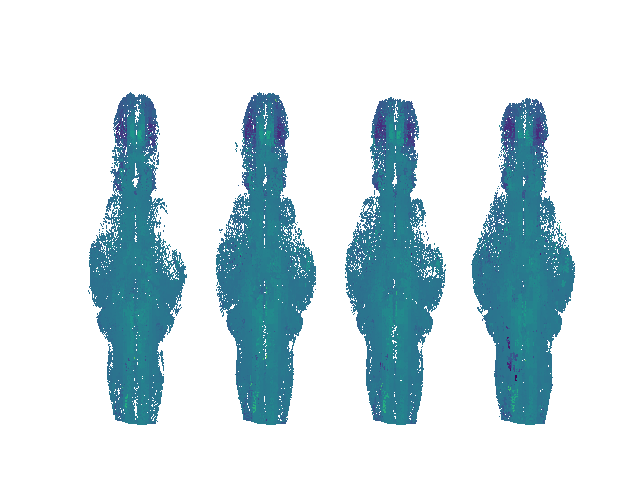

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [22]:
mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]
    
    lm_n = sp_posteriors[s_n].lm_post(neuron_locs_n).detach().numpy()
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])   

## Setup everything for fitting models with individual posteriors

In [23]:
ip_priors = copy.deepcopy(sp_priors)

ip_posteriors = generate_basic_posteriors(n_obs_vars=[fit_data_conc[s_n].shape[1] for s_n in subjects], 
                                          n_smps=[fit_data_conc[s_n].shape[0] for s_n in subjects], 
                                          n_latent_vars=ps['n_latent_vars'], 
                                          n_intermediate_latent_vars=ps['n_intermediate_latent_vars'],
                                          s_opts={'mn_mn': ps['s_mn'], 'mn_std': .00000001, 
                                                  'std_lb': ps['s_std']-.0001, 'std_iv': ps['s_std']})
ip_posteriors = {s_n: ip_posteriors[s_i] for s_i, s_n in enumerate(subjects)}

In [24]:
for s_n, posteriors in ip_posteriors.items():
    
    # Initialize the poseteriors for the mean vectors
    with torch.no_grad():
        mn_prior_mn = sp_priors.mn_prior(neuron_locs[s_n]).squeeze()
        mn_prior_std = sp_priors.mn_prior.std_f(neuron_locs[s_n]).squeeze()
    
        posteriors.mn_post.dists[0].mn_f.f.vl.data = copy.deepcopy(mn_prior_mn)
        posteriors.mn_post.dists[0].std_f.f.set_value(copy.deepcopy(mn_prior_std.numpy()))
        
    # Initialize the posteriors for the loading matrices
    with torch.no_grad():
        for d_i in range(ps['n_intermediate_latent_vars']):
            lm_prior_mn = sp_priors.lm_prior.dists[d_i](neuron_locs[s_n]).squeeze()
            lm_prior_std = sp_priors.lm_prior.dists[d_i].std_f(neuron_locs[s_n]).squeeze()
            
            posteriors.lm_post.dists[d_i].mn_f.f.vl.data = copy.deepcopy(lm_prior_mn)
            posteriors.lm_post.dists[d_i].std_f.f.set_value(copy.deepcopy(lm_prior_std.numpy()))
        
    # Initialize the posteriors for the private variances
    posteriors.psi_post = copy.deepcopy(sp_posteriors[s_n].psi_post)
    
    # Initialize the posteriors for the latents
    with torch.no_grad():
        posteriors.latent_post = copy.deepcopy(sp_posteriors[s_n].latent_post)

In [25]:
ip_fit_mdls = {s_n: GNLDRMdl(n_latent_vars=ps['n_latent_vars'], m=sp_m_fit) for s_n in subjects}

ip_vi_collections = [VICollection(data=torch.tensor(fit_data_conc[s_n]), 
                                  props=neuron_locs[s_n],
                                  mdl = ip_fit_mdls[s_n],
                                  posteriors = ip_posteriors[s_n])
                     for s_n in subjects]

## Fit the ip models

In [26]:
ip_fitter = Fitter(vi_collections=ip_vi_collections, priors=ip_priors)

In [27]:
ip_fitter.distribute(distribute_data=True, devices=devices)
ip_log = ip_fitter.fit(1000, milestones=[300, 500, 700], update_int=100, init_lr=0.001,
                       skip_lm_kl=False, skip_mn_kl=False, skip_psi_kl=False, 
                       cp_save_folder=ps['cp_save_folder'], cp_epochs=np.arange(0, 1000, 100))
#ip_fitter.distribute(devices=[torch.device('cpu')])


=========== EPOCH 0 COMPLETE ===========
Obj: 2.26e+08
----------------------------------------
NELL: 1.27e+08, 3.33e+07, 2.28e+07, 3.49e+07
Latent KL: 1.82e+04, 4.76e+03, 3.08e+03, 5.10e+03
LM KL: 6.24e+02, 6.98e+02, 7.37e+02, 8.79e+02
Mn KL: 2.70e+02, 3.10e+02, 3.26e+02, 3.95e+02
Psi KL: 7.24e+04, 8.03e+04, 8.24e+04, 8.85e+04
S KL: 1.73e+06, 1.99e+06, 2.08e+06, 2.54e+06
----------------------------------------
LR: 0.001
Elapsed time (secs): 0.4595012664794922
----------------------------------------
CPU cur memory used (GB): 3.31e+01
GPU_0 cur memory used (GB): 8.63e-01, max memory used (GB): 8.63e-01
Saved check point for epoch 0.

=========== EPOCH 100 COMPLETE ===========
Obj: 2.15e+08
----------------------------------------
NELL: 1.25e+08, 3.26e+07, 2.23e+07, 3.43e+07
Latent KL: 1.83e+04, 4.72e+03, 3.15e+03, 5.04e+03
LM KL: 1.97e+05, 3.77e+04, 2.20e+04, 1.68e+04
Mn KL: 1.26e+05, 1.28e+05, 1.29e+05, 1.52e+05
Psi KL: 7.21e+04, 7.99e+04, 8.22e+04, 8.83e+04
S KL: 2.85e+01, 7.92e+00

## Evaluate performance across check points on validation performance

In [28]:
cp_epochs, cp_elbo = evaluate_check_points(cp_folder=ps['cp_save_folder'], 
                              data=[torch.tensor(validation_data_conc[k]) for k in validation_data_conc.keys()], 
                              props=[neuron_locs[k] for k in neuron_locs.keys()], 
                              n_smps=100, device=devices[0])

Done with check point: 1 of 10.
Done with check point: 2 of 10.
Done with check point: 3 of 10.
Done with check point: 4 of 10.
Done with check point: 5 of 10.
Done with check point: 6 of 10.
Done with check point: 7 of 10.
Done with check point: 8 of 10.
Done with check point: 9 of 10.
Done with check point: 10 of 10.


## View validation peformance across checkpoints

<IPython.core.display.Javascript object>


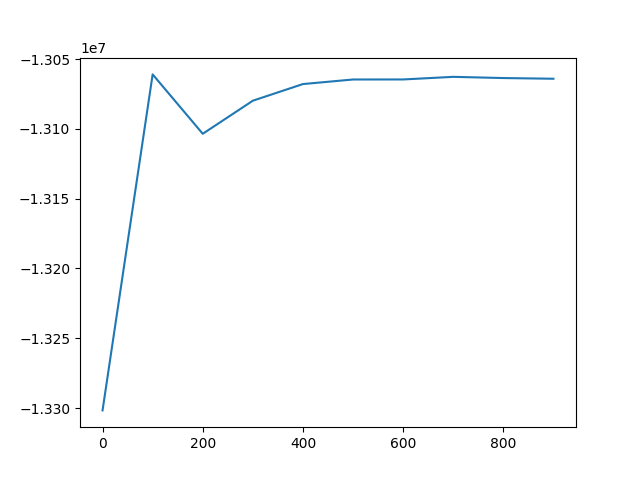

In [29]:
plt.figure()
plt.plot(cp_epochs, np.mean(cp_elbo, axis=1))

## Pick the best ip model based on early stopping

In [30]:
if ps['use_early_stopping']:
    best_cp_epoch = cp_epochs[np.argmax(np.mean(cp_elbo, axis=1))].astype('int')
    print('Best epoch is ' + str(best_cp_epoch) + '.')

    best_cp = torch.load(Path(ps['cp_save_folder']) / ('cp_' + str(best_cp_epoch) + '.pt'))    
    ip_eval_vi_collections = [VICollection.from_checkpoint(coll_d) for coll_d in best_cp['vi_collections']]
    for c_i, coll in enumerate(ip_eval_vi_collections):
        coll.props = ip_vi_collections[c_i].props
    ip_eval_priors = PriorCollection.from_checkpoint(best_cp['priors'])
    
else:
    ip_eval_vi_collections = ip_vi_collections
    ip_eval_priors = ip_priors
    
ip_eval_posteriors = {s_n: ip_eval_vi_collections[s_i].posteriors for s_i, s_n in enumerate(subjects)}

Best epoch is 100.


## Infer latents with the ip models for the validation data

In [31]:
ip_validation_latent_posts ={s_n: infer_latents(n_latent_vars=ps['n_latent_vars'],
                                                vi_collection=ip_eval_vi_collections[s_i],
                                                data=torch.tensor(validation_data_conc[s_n]),
                                                fit_opts={'n_epochs': 1000, 'init_lr':.1, 'update_int':None, 
                                                          'milestones': [500]}, 
                                                device=devices[0])[0]
                         for s_i, s_n in enumerate(subjects)}

In [32]:
ip_fitter.distribute(devices=[torch.device('cpu')])

## View fitting log for ip models

<IPython.core.display.Javascript object>


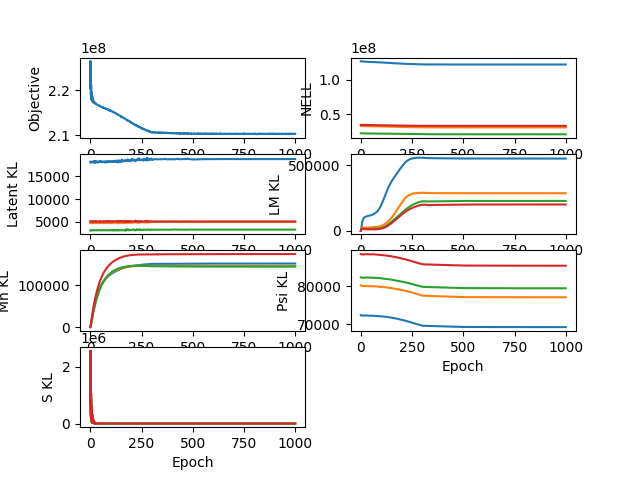

In [33]:
ip_fitter.plot_log(ip_log)

## View latents estimated with the sp models

In [34]:
view_validaton = False # True if we should view validation latents

In [35]:
ip_latents = {s_n: ip_posteriors[s_n].latent_post.mns.detach().numpy() for s_n in subjects}

<IPython.core.display.Javascript object>


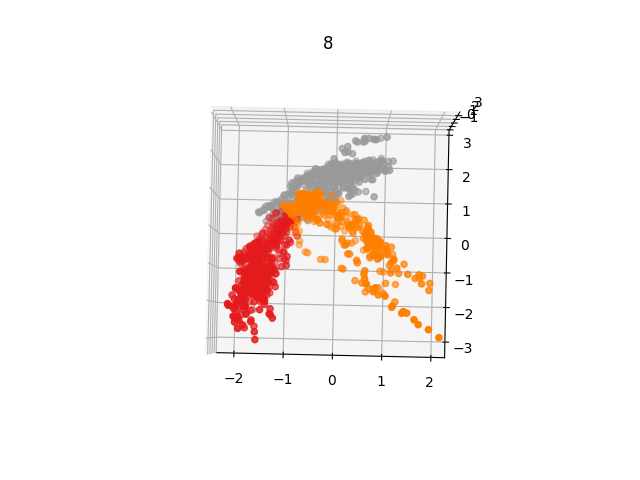

<IPython.core.display.Javascript object>


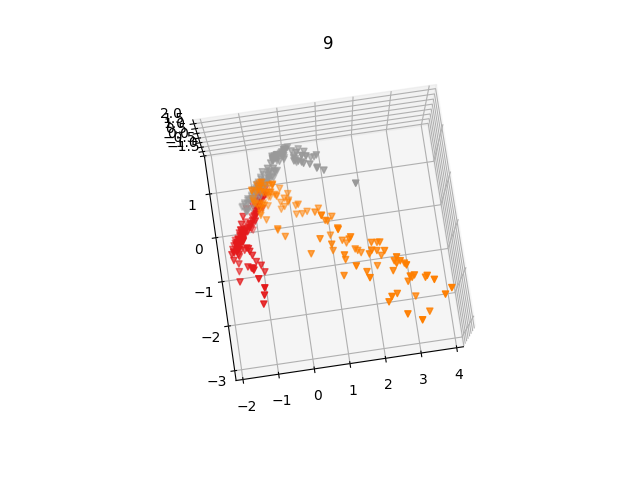

<IPython.core.display.Javascript object>


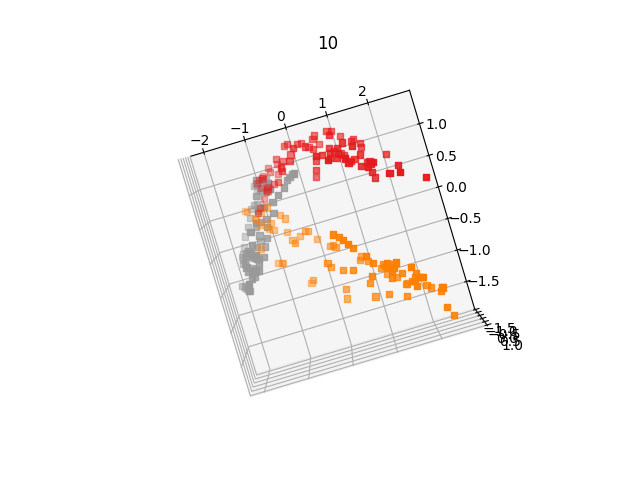

<IPython.core.display.Javascript object>


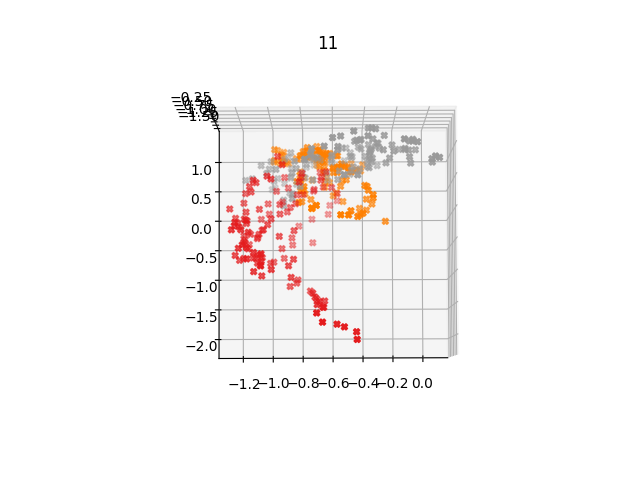

In [36]:
start_dim=0


for s_n in subjects:
    plt.figure()
    ax = plt.axes(projection='3d')
    plot_latents = ip_latents[s_n]
    if view_validaton:
        plot_labels = validation_labels_conc[s_n]
    else:
        plot_labels = fit_labels_conc[s_n]
    
    for sp, sp_lbl in label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_latents[sp_inds,start_dim+0], plot_latents[sp_inds,start_dim+1], 
                   plot_latents[sp_inds,start_dim+2], color=sp_clr, marker=subject_markers[s_n])
    plt.title(str(s_n))

## Visualize loading matrices across space for the ip models

In [37]:
vis_comp = 0

<IPython.core.display.Javascript object>


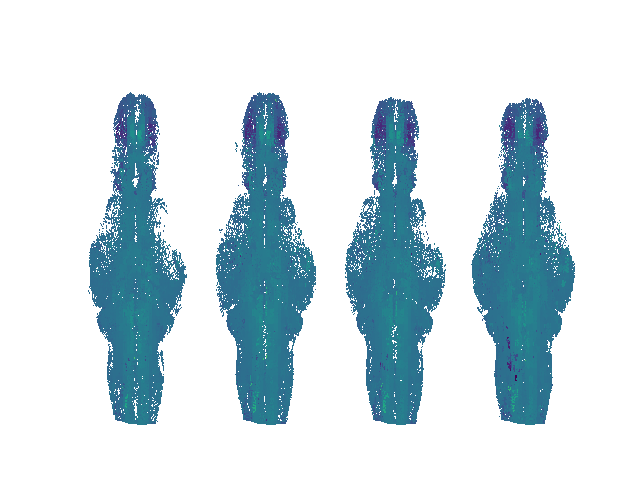

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]

In [38]:
mode_imgs = dict()
for s_n in subjects:
    neuron_locs_n = neuron_locs[s_n]
    
    lm_n = ip_posteriors[s_n].lm_post(neuron_locs_n).detach().numpy()
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])   